# Questionnaire processing

In [1]:
questionnaire_csv = './Space Engineers PCG Questionnaire.csv'
file_uploads_dir = './Space Engineers PCG Questionnaire (File responses)'

questions_place = {
    'A': 'Solution satisfaction',
    'B': 'System efficiency',
    'C': 'Runtime response',
    'D': 'User fatigue'
} 

scale = ['', 'Poor', 'Fair', 'Good', 'Excellent']

samples_name = ['Human', 'Random', 'Greedy', 'Contextual Bandit']

experiments = {
    'Human': {
        'solution_satisfaction': [],
        'system_efficiency': [],
        'runtime_response': [],
        'user_fatigue': [],
        'time_elapsed': [],
        'n_interactions': [],
        'scores': []
    },
    'Random': {
        'solution_satisfaction': [],
        'system_efficiency': [],
        'runtime_response': [],
        'user_fatigue': [],
        'time_elapsed': [],
        'n_interactions': [],
        'scores': []
    },
    'Greedy': {
        'solution_satisfaction': [],
        'system_efficiency': [],
        'runtime_response': [],
        'user_fatigue': [],
        'time_elapsed': [],
        'n_interactions': [],
        'scores': []
    },
    'Contextual Bandit': {
        'solution_satisfaction': [],
        'system_efficiency': [],
        'runtime_response': [],
        'user_fatigue': [],
        'time_elapsed': [],
        'n_interactions': [],
        'scores': []
    },
}

user_friendliness = []
feedbacks = []
n_volunteers = 0

In [2]:
needs_anonymizing = False

In [3]:
import random

def order_by_rng(rng_seed):
    random.seed(rng_seed)
    my_emitterslist = samples_name.copy()
    random.shuffle(my_emitterslist)
    return my_emitterslist

## Anonymize file uploads

Files in `file_uploads_dir` are metrics and configurations ranking, but contain the name of the uploader.

In [4]:
import os

if needs_anonymizing:
    files = os.listdir(file_uploads_dir)
    for f in files:
        prefix, name_ext = f.split(' - ')
        ext = name_ext.split('.')[1]
        os.rename(os.path.join(file_uploads_dir, f),
                os.path.join(file_uploads_dir, f'{prefix}.{ext}'))

## Load the `csv` file

In [5]:
import csv
import json

with open(questionnaire_csv, newline='', encoding='utf8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',', quotechar='"')
    
    for row in reader:
        rng_seed = int(row['Please insert here the ID of your experiment'])
        experiments_order = order_by_rng(rng_seed=rng_seed)
        for i, v in enumerate(experiments_order):
            experiments[v]['solution_satisfaction'].append(int(row[f'({i + 1}) Solution satisfaction']))
            experiments[v]['system_efficiency'].append(int(row[f'({i + 1}) System efficiency']))
            experiments[v]['runtime_response'].append(int(row[f'({i + 1}) Runtime response']))
            experiments[v]['user_fatigue'].append(int(row[f'({i + 1}) User fatigue']))
        
        with open(os.path.join(file_uploads_dir, f'{rng_seed}_res.json'), 'r') as f:
            scores = json.loads(f.read())
            for v in experiments_order:
                experiments[v]['scores'].append(int(scores[v]))
        
        with open(os.path.join(file_uploads_dir, f'user_metrics_{rng_seed}.txt')) as f:
            metrics = json.loads(f.read())
            for metric in metrics.keys():
                for v in experiments_order:
                    experiments[v][metric].append(metrics[metric][samples_name.index(v)])
        
        user_friendliness.append(int(row['User-friendliness']))
        feedbacks.append(row['Please provide any additional feedback.'])
        
        n_volunteers += 1

In [6]:
import numpy as np

print('### Experiments feedback ###')
print(f'Average user-friendliness: {np.mean(user_friendliness)}')
print('Additional feedbacks: ')
for f in feedbacks:
    if f:
        print(f)
print('###        -----        ###')

### Experiments feedback ###
Average user-friendliness: 3.0
Additional feedbacks: 
###        -----        ###


In [ ]:
samples = [np.asarray(experiments[v]['scores']) for v in samples_name]

## Plots

In [7]:
import matplotlib.pyplot as plt
import numpy as np

feedback_keys = ['solution_satisfaction', 'system_efficiency', 'runtime_response', 'user_fatigue']

### Feedback per experiment

C:\Users\rober\AppData\Local\Temp\ipykernel_37604\2381783577.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axd[plot_idx].set_xticklabels(scale)


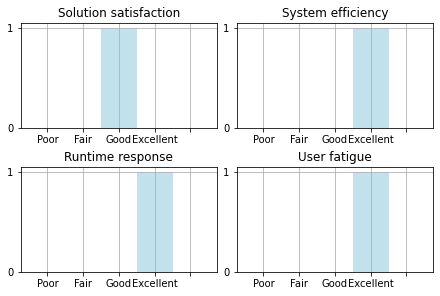

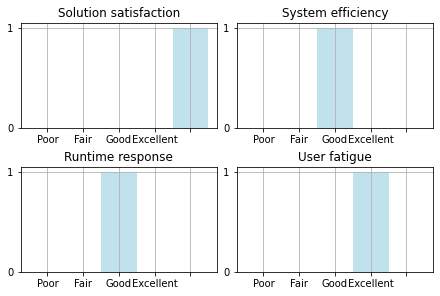

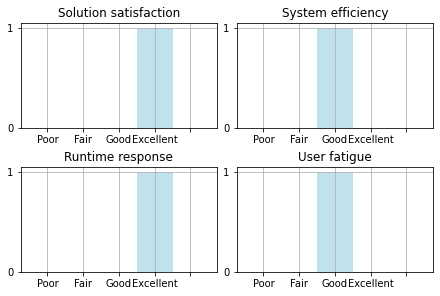

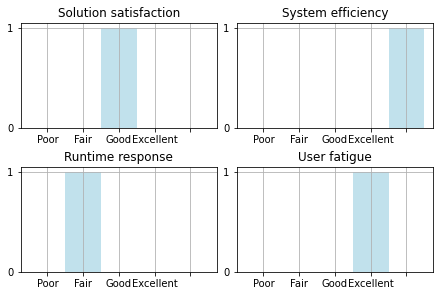

In [8]:
user_feedback = {v:{k: {i: 0 for i in range(len(scale))} for k in feedback_keys} for v in samples_name}

for sample in samples_name:
    for k in feedback_keys:
        for v in experiments[sample][k]:
            user_feedback[sample][k][v] += 1

for sample in samples_name:
    axd = plt.figure(constrained_layout=True).subplot_mosaic(
        """
        AB
        CD
        """
    )

    for i, (plot_idx, metric) in enumerate(questions_place.items()):
        axd[plot_idx].bar(np.arange(len(scale)), [user_feedback[sample][metric.replace(' ', '_').lower()][j] for j in range(len(scale))], 1, color='lightblue', alpha=0.75)
        axd[plot_idx].set_xticklabels(scale)
        axd[plot_idx].set_yticks(np.arange(0, n_volunteers + 1, 1))
        axd[plot_idx].set_title(questions_place[plot_idx])
        axd[plot_idx].grid()

    # plt.suptitle(f'Questionnaire responses distribution ({sample} emitter)')

    plt.savefig(f'./plots/questionnaire-plots-{sample.replace(" ", "_").lower()}')
    
    plt.show()

### Average feedback

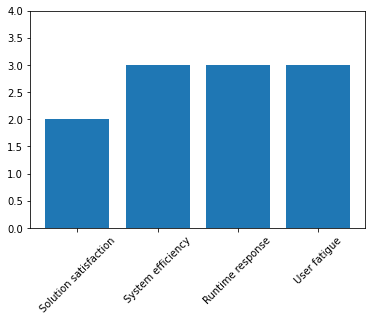

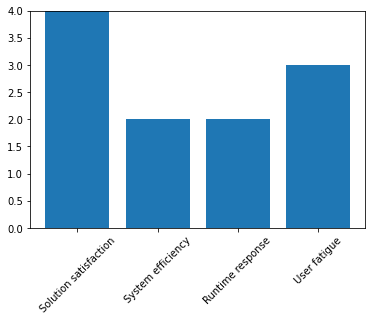

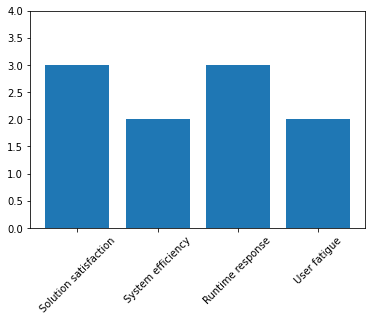

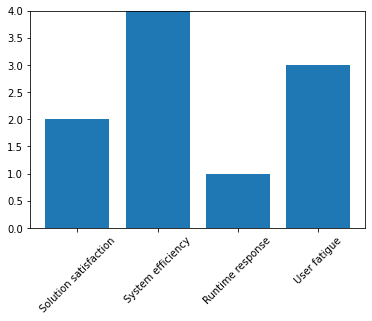

In [9]:
avg_response = {v:{k: np.mean(experiments[v][k]) for k in feedback_keys} for v in samples_name}

for sample in samples_name:
    plt.bar(questions_place.values(), [avg_response[sample][k] for k in feedback_keys])
    plt.ylim(0, len(feedback_keys))
    plt.xticks(rotation = 45)
    # plt.title(f'Average category score ({sample} emitter)')
    plt.savefig(f'./plots/avg-category-score-{sample.replace(" ", "_").lower()}')
    plt.show()

### Rankings

./plots/emitters-rankings


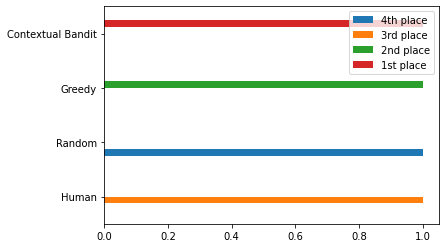

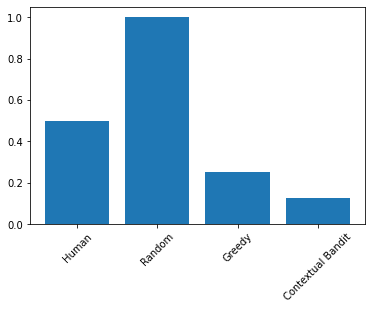

In [ ]:
from pcgsepy.stats.plots import plot_rankings
from pcgsepy.stats.plots import plot_scores

plot_rankings(samples=samples,
              labels=['4th place', '3rd place', '2nd place', '1st place'],
              names=samples_name,
              title='',
              filename='./plots/emitters-rankings')

plot_scores(samples=samples,
            names=samples_name,
            score_to_value={1: 1, 2: 0.5, 3: 0.25, 4: 0.125},
            title='',
            filename='./plots/emitters-score')

## LaTeX tables

In [35]:
table = """
\\begin{table}[!t]
    \\centering
    \\resizebox{.4\\textwidth}{!}{%
        \\begin{tabular}{c|c|c|c|c|}
            \\cline{2-5}
            \\multicolumn{1}{l|}{}                                            & Poor  & Fair & Good & Excellent \\\\ \hline
            \\multicolumn{1}{|c|}{Solution satisfaction}                      & SSPOOR    & SSFAIR    & SSGOOD    & SSEXCELLENT         \\\\ \hline
            \\multicolumn{1}{|c|}{System efficiency}                          & SEPOOR    & SEFAIR    & SEGOOD    & SEEXCELLENT         \\\\ \hline
            \\multicolumn{1}{|c|}{Runtime response}                           & RRPOOR    & RRFAIR    & RRGOOD    & RREXCELLENT         \\\\ \hline
            \\multicolumn{1}{|c|}{User fatigue}                               & UFPOOR    & UFFAIR    & UFGOOD    & UFEXCELLENT         \\\\ \hline
        \\end{tabular}
    }
    \\caption{Questionnaire results obtained with N candidates using the EMITTERNAME2 emitter.}
    \\label{tab:questionnaire-EMITTERNAME1}
\end{table}"""

In [36]:
for sample in samples_name:
    emitter_table = table.replace('EMITTERNAME1', sample.replace(' ', '_').lower())
    emitter_table = emitter_table.replace('EMITTERNAME2', sample)
    
    emitter_table = emitter_table.replace('SSPOOR', str(user_feedback[sample]['solution_satisfaction'][1]))
    emitter_table = emitter_table.replace('SSFAIR', str(user_feedback[sample]['solution_satisfaction'][2]))
    emitter_table = emitter_table.replace('SSGOOD', str(user_feedback[sample]['solution_satisfaction'][3]))
    emitter_table = emitter_table.replace('SSEXCELLENT', str(user_feedback[sample]['solution_satisfaction'][4]))
    
    
    emitter_table = emitter_table.replace('SEPOOR', str(user_feedback[sample]['system_efficiency'][1]))
    emitter_table = emitter_table.replace('SEFAIR', str(user_feedback[sample]['system_efficiency'][2]))
    emitter_table = emitter_table.replace('SEGOOD', str(user_feedback[sample]['system_efficiency'][3]))
    emitter_table = emitter_table.replace('SEEXCELLENT', str(user_feedback[sample]['system_efficiency'][4]))
    
    
    emitter_table = emitter_table.replace('RRPOOR', str(user_feedback[sample]['runtime_response'][1]))
    emitter_table = emitter_table.replace('RRFAIR', str(user_feedback[sample]['runtime_response'][2]))
    emitter_table = emitter_table.replace('RRGOOD', str(user_feedback[sample]['runtime_response'][3]))
    emitter_table = emitter_table.replace('RREXCELLENT', str(user_feedback[sample]['runtime_response'][4]))
    
    
    emitter_table = emitter_table.replace('UFPOOR', str(user_feedback[sample]['user_fatigue'][1]))
    emitter_table = emitter_table.replace('UFFAIR', str(user_feedback[sample]['user_fatigue'][2]))
    emitter_table = emitter_table.replace('UFGOOD', str(user_feedback[sample]['user_fatigue'][3]))
    emitter_table = emitter_table.replace('UFEXCELLENT', str(user_feedback[sample]['user_fatigue'][4]))
    
    emitter_table = emitter_table.replace('N', str(n_volunteers))
    
    print(emitter_table)


\begin{table}[!t]
    \centering
    \resizebox{.5\textwidth}{!}{%
        \begin{tabular}{c|c|c|c|c|}
            \cline{2-5}
            \multicolumn{1}{l|}{}                                            & Poor  & Fair & Good & Excellent \\ \hline
            \multicolumn{1}{|c|}{Solution satisfaction}                      & 0    & 1    & 0    & 0         \\ \hline
            \multicolumn{1}{|c|}{System efficiency}                          & 0    & 0    & 1    & 0         \\ \hline
            \multicolumn{1}{|c|}{Runtime response}                           & 0    & 0    & 1    & 0         \\ \hline
            \multicolumn{1}{|c|}{User fatigue}                               & 0    & 0    & 1    & 0         \\ \hline
        \end{tabular}
    }
    \label{tab:questionnaire-human}
    \caption{Questionnaire results obtained with 1 candidates using Human emitter.}
\end{table}

\begin{table}[!t]
    \centering
    \resizebox{.5\textwidth}{!}{%
        \begin{tabular}{c|c|c|c|c|}
       

## Tests

### Shapiro-Wilk

In [11]:
from pcgsepy.stats.tests import shapiro_wilk

print('## SHAPIRO-WILK TEST ##')

shapiro_test = shapiro_wilk(samples=samples)

for (stat, pvalue), name in zip(shapiro_test, samples_name):
    print(f'Result score for {name}:')
    print(f'\tStatistic: {stat}')
    print(f'\tp-value: {pvalue}')

## SHAPIRO-WILK TEST ##


ValueError: Data must be at least length 3.

### One-way ANOVA

In [ ]:
import itertools
from pcgsepy.stats.tests import anova, THRESHOLD_PVALUE

print('## ONE-WAY ANOVA TEST ##')

anova_test = anova(samples=samples)

overall_stat, overall_pvalue = anova_test[0]

print('Overall score:')
print(f'\tStatistic: {overall_stat}')
print(f'\tp-value: {overall_pvalue}')

if overall_pvalue < THRESHOLD_PVALUE:
    for (stat, pvalue), name in zip(anova_test[1:], itertools.combinations(iterable=samples_name, r=2)):
        print(f'Result score for {" x ".join(list(name))}:')
        print(f'\tStatistic: {stat}')
        print(f'\tp-value: {pvalue}')

### Kruskal-Wallis

In [ ]:
import itertools
from pcgsepy.stats.tests import kruskal_wallis

print('## KRUSKAL-WALLIS TEST ##')

kruskal_wallis_test = kruskal_wallis(samples=samples)

overall_stat, overall_pvalue = kruskal_wallis_test[0]

print('Overall score:')
print(f'\tStatistic: {overall_stat}')
print(f'\tp-value: {overall_pvalue}')

if overall_pvalue < THRESHOLD_PVALUE:
    for (stat, pvalue), name in zip(kruskal_wallis_test[1:], itertools.combinations(iterable=samples_name, r=2)):
        print(f'Result score for {" x ".join(list(name))}:')
        print(f'\tStatistic: {stat}')
        print(f'\tp-value: {pvalue}')